In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1.데이터 불러오기

In [17]:
df_org = pd.read_csv('/content/drive/MyDrive/ASAC3기_이상탐지/Code/5주차/이승용/train.csv')

In [18]:
df = df_org.copy()

In [19]:
df.head(3)

,ckey,machine_id,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,Y
0,MA1074_4-20210901-0,MA1074_4,20210901,0,17.598889,32.0,99.763033,100.000000,100.000000,30.361451,35.072902,101.157849,0.0
1,MA1074_4-20210901-1,MA1074_4,20210901,1,13.039444,25.0,99.661017,99.516908,99.367089,22.009545,30.845568,101.483722,0.0
2,MA1074_4-20210901-2,MA1074_4,20210901,2,10.153889,23.0,99.583333,99.411765,100.000000,16.333186,11.431835,101.656051,0.0


# 2.Y레이블 확인

In [20]:
df['time'] = pd.to_datetime(df['date'].astype(str) + df['hour'].astype(str), format='%Y%m%d%H')

In [21]:
for key, val in df['Y'].value_counts().items():
    print(key, val)

0.0 3803
1.0 589


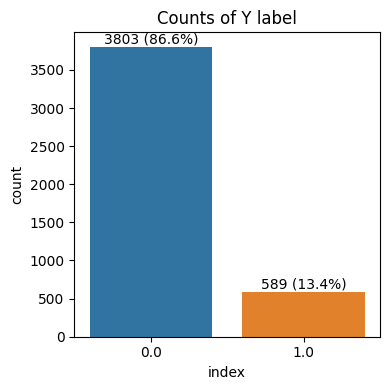

In [22]:
count_y = df['Y'].value_counts().to_frame('count').reset_index()
plt.figure(figsize=(4,4))
plt.title('Counts of Y label')
sns.barplot(data = count_y, x='index', y='count')
for key, val in df['Y'].value_counts().items():
    pct =(val / df.shape[0]) * 100
    plt.text(key, val, s=f'{val} ({pct:.1f}%)', ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [23]:
target_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate']

In [24]:
df.groupby('Y')[target_columns].mean(numeric_only=True)

,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate
Y,,,,,,,,
0.0,15.341680,29.777397,92.180183,99.859779,99.613395,21.836627,14.392330,98.222998
1.0,8.073922,17.144312,69.002764,99.655979,99.154427,14.533581,20.157082,102.973753


In [25]:
df.groupby(['machine_id', 'Y'])[target_columns].mean(numeric_only=True).style.background_gradient()

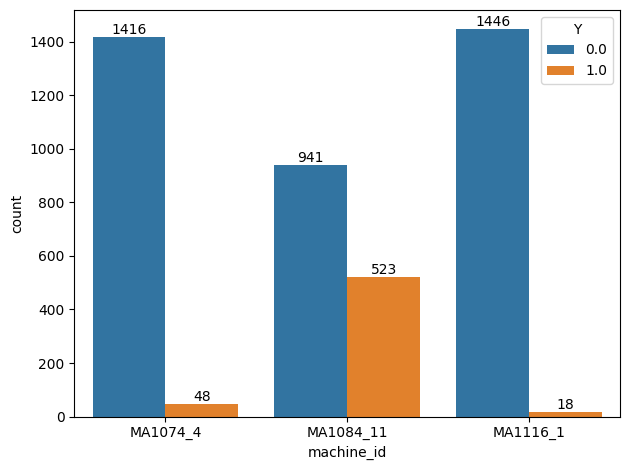

In [26]:
machine_count_y = df.groupby(['machine_id','Y']).size().to_frame('count').reset_index()


fig, ax = plt.subplots()
bar_container = sns.barplot(data=machine_count_y, x='machine_id', y='count', hue='Y', ax=ax)
# ax.bar_label(bar_container) #, fmt=lambda x: f'{x * 1.61:.1f} km/h')
for i in ax.containers:
    ax.bar_label(i, fmt='%.0f')
plt.tight_layout()
plt.show()

In [27]:
print('Machine ID List :', df['machine_id'].unique().tolist())
print('Main Features :', target_columns)

Machine ID List : ['MA1074_4', 'MA1084_11', 'MA1116_1']
Main Features : ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate']


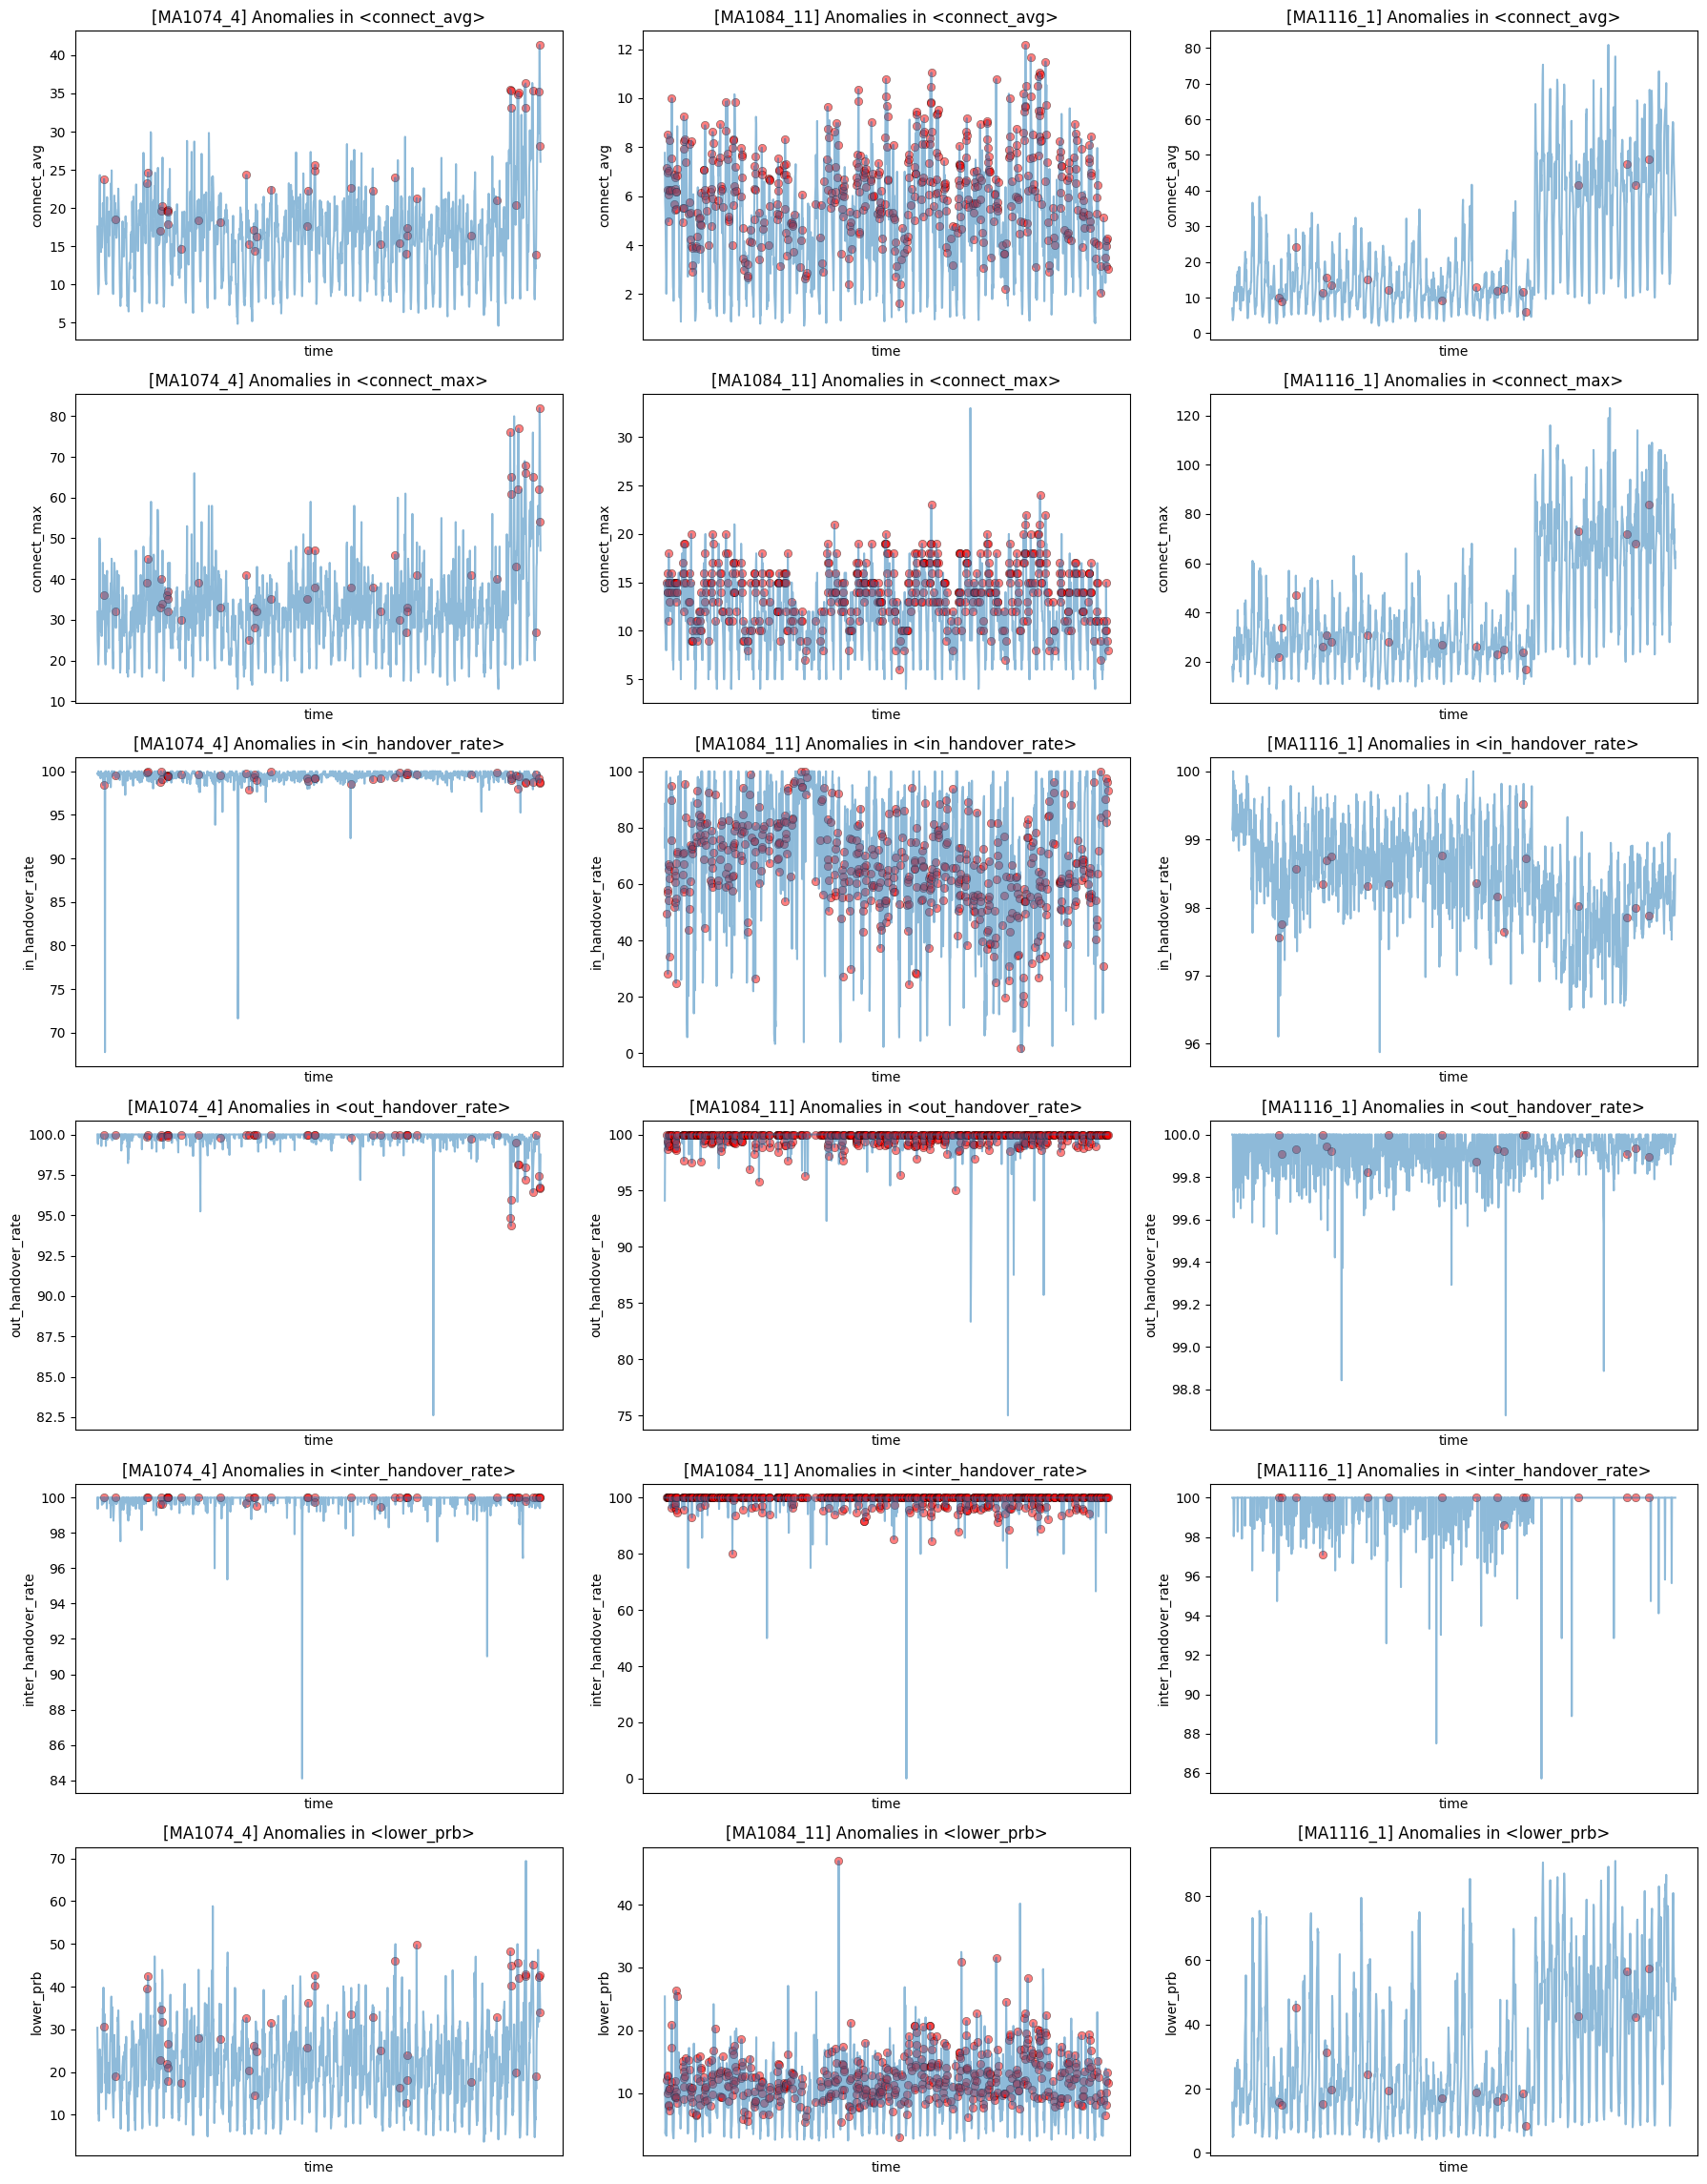

In [28]:
machine_id_list = df['machine_id'].unique()

fig, axs = plt.subplots(6, 3, figsize=(18,23))
for i in range(18):
    rows = i // 3
    cols = i % 3

    target_column = target_columns[rows]
    machine_id = machine_id_list[cols]

    tmp = df[df['machine_id']==machine_id]
    anomalies = tmp[tmp['Y']==1.0]
    sns.lineplot(data=tmp, x=tmp.time, y=target_column, ax=axs[rows,cols], alpha=0.5)
    axs[rows,cols].set_title(f'[{machine_id}] Anomalies in <{target_column}>')
    axs[rows,cols].set_xticks([])

    sns.scatterplot(data = anomalies, x=anomalies.time, y=target_column, color='red', marker='o', edgecolor='k', ax=axs[rows, cols], alpha=0.5)

plt.tight_layout()
plt.show()

# 3.데이터 전처리

## 3.1 trainX, trainY

In [29]:
train = df_org.copy()

- 결측치 처리

In [30]:
# train.fillna(method='ffill', inplace=True)
train = train.interpolate(method='linear')

In [31]:
train['time'] = pd.to_datetime(train['date'].astype(str)+train['hour'].astype(str), format='%Y%m%d%H')

In [32]:
trainX = train.drop(['ckey', 'machine_id', 'Y'], axis=1)
trainY = train['Y']

In [33]:
trainX.shape, trainY.shape

((4392, 11), (4392,))

## 3.3 datetime

In [34]:
trainX.sample()

,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,time
3483,20210924,3,4.159444,12.0,98.200514,100.0,100.0,6.579602,11.093713,89.551478,2021-09-24 03:00:00


In [35]:
trainX['year'] = trainX['time'].dt.year
trainX['month'] = trainX['time'].dt.month
trainX['day'] = trainX['time'].dt.day
trainX['hour'] = trainX['time'].dt.hour
trainX['dayofweek'] = trainX['time'].dt.dayofweek

In [36]:
print(target_columns)

['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate']


## 3.3 train_test_split

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.2, random_state=0, stratify=trainY)

In [38]:
print(y_train.value_counts(normalize=True))
print()
print(y_test.value_counts(normalize=True))

0.0    0.865927
1.0    0.134073
Name: Y, dtype: float64

0.0    0.865757
1.0    0.134243
Name: Y, dtype: float64


## 추가)클래스 불균형
출처 : [불균형 데이터 분석을 위한 샘플링 기법](https://youtu.be/Vhwz228VrIk?si=v_8daObV3lctdNNI)
- 데이터를 조정해서 해결
    - 1) 샘플링 기법(Sampling Method)

- 모델을 조정해서 해결
    - 1) 비용 기반 학습 (Cost sensitive learning)
    - 2) 단일 클래스 분류기법 (Novelty detection)

- Undersampling
    - Random undersampling
        - 다수 범주에서 무작위로 샘플링
        - 랜덤 방식이기 때문에 샘플링할 때마다 다른 결과가 도출됨 (이론 상)
    - Tomek links
        - d(xi,xk) < d(xi,xj) 또는 d(xj,xk) < d(xi, xj)가 되는 관측치 xk가 없는 경우 => xi와 xj는 Tomek links 형성
        - 이 중 다수 범주에 해당하는 관측치 xi를 제거
    - Condensed Nearest Neighbor Rule(CNN)
        - 소수 범주 전체와 다수 범주에서 무작위로 하나의 관측치를 선택하여 서브데이터 구성
        - 1-NN 알고리즘을 통해 정상 데이터를 분류
        - 정상 분류된 다수 범주 관측치를 제거
        - 반드시 k=1이어야 함
    - One-sided selection(OSS)
        - Tomek links + CNN
    - 효과
        - 장점 : 다수 범주 관측치 제거로 계산 시간 감소
        데이터 클랜징으로 클래스 오버랩 감소 가능
        - 단점 : 데이터 제거로 인한 정보 손실

- Oversampling
    - Resampling
        - 소수 범주 내 데이터를 무작위로 그대로 복사하여 증폭
        - 단, 소수 클래스에 과적합되는 단점 존재
    - SMOTE(Synthetic MInority Oversampling Technique)
        - 소수 범주에서 가상의 데이터 생성
        - 소수 클래스 데이터에서 하나의 관측치를 선택한 후 k=5로 하여 이웃 지정 (k>=2)
        - 이 중 랜덤하게 1개 선택
            - Synthetic = X + u * (X(nn)-X)
                - X : 소수 클래스 관측치
                - u : 균등분포(unif(0,1))
                - X(nn) : 주변 관측치
    - Borderline-SMOTE
        - 경계선 부분만을 오버샘플링하는 방법
        - 분류경계면을 만드는데 도움이 되는 샘플을 생성하자는 아이디어
        - 소수 클래스 xi에 대해서 k 최근접 이웃을 탐색
        - k개 이웃 중 다수 클래수의 수 확인
            - 다수 클래스 수가 많으면 Danger 관측치(borderline 인근 데이터로 해석가능)
            - 다수 클래스 수가 적으면 Safe
            - 전부 다수 클래스에 속하면 Noise관측치(borderline이 아님)
        - Danger 관측치에 대해서만 SMOTE 적용
    - ADASYN
        - 샘플링하는 개수를 위치에 따라 다르게 적용
        - 각 소수 클래스 주변에 얼마나 많은 다수 클래스 관측치가 있는지 비율 계산(ri)
            - 모든 소수 클래스에 대해 ri계산
            - ri값은 전체 합산으로 나누어 스케일링
        - G = 다수 클래스 개수 - 소수 클래스 개수
        - 모든 ri값에 G를 곱하여 생성할 소수 클래스 수를 구함
        - 소수 클래스 주변의 다수 클래스의 수에 따라 유동적으로 oversampling 개수를 정할 수 있음
        - 다수 클래스 주변에 있는 소수 클래스에 집중

    - GAN(Generative Adversarial Nets)

In [39]:
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

In [40]:
trainX.sample()

,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,time,year,month,day,dayofweek
3533,20210926,5,3.318889,10.0,99.045802,100.0,100.0,5.086344,1.012105,92.426778,2021-09-26 05:00:00,2021,9,26,6


In [41]:
X_train.drop('time', axis=1, inplace=True)

In [42]:
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_smote).items()))

[(0.0, 3042), (1.0, 3042)]


In [43]:
# X_resampled, y_resampled = ADASYN().fit_resample(X, y)
# print(sorted(Counter(y_resampled).items()))

In [44]:
# clf_adasyn = LogisticRegression().fit(X_resampled, y_resampled)

### 1) Upsampling 전/후

In [45]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [46]:
# pca_before = PCA(n_components=2, random_state=0)
# pca = pca_before.fit_transform(X_train)

tsne_before = TSNE(n_components=2, random_state=0)
tsne = tsne_before.fit_transform(X_train)

In [47]:
# pca_x1 = pca[:,0]
# pca_x2 = pca[:,1]
# before_upsampling = pd.DataFrame({'pca_x1':pca_x1,
#                                   'pca_x2':pca_x2,
#                                   'target':y_train})

tsne_x1 = tsne[:,0]
tsne_x2 = tsne[:,1]
before_upsampling = pd.DataFrame({'tsne_x1':tsne_x1,
                                  'tsne_x2':tsne_x2,
                                  'target':y_train})

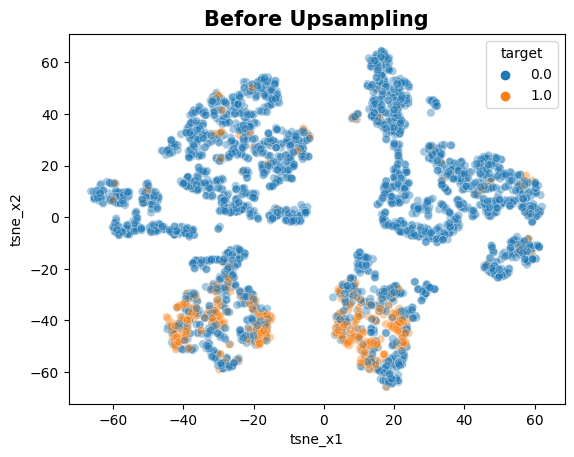

In [48]:
# sns.scatterplot(data=before_upsampling, x='pca_x1', y='pca_x2', hue='target', alpha=0.4)
# plt.title('Before Upsampling', fontsize=15, fontweight='semibold')
# plt.show()

sns.scatterplot(data=before_upsampling, x='tsne_x1', y='tsne_x2', hue='target', alpha=0.4)
plt.title('Before Upsampling', fontsize=15, fontweight='semibold')
plt.show()

In [49]:
# pca_after = PCA(n_components=2, random_state=0)
# smote_pca = pca_after.fit_transform(X_train_smote)

tsne_after = TSNE(n_components=2, random_state=0)
smote_tsne = tsne_after.fit_transform(X_train_smote)

In [50]:
# pca_x1_sm = smote_pca[:,0]
# pca_x2_sm = smote_pca[:,1]
# after_upsampling = pd.DataFrame({'pca_x1':pca_x1_sm,
#                                  'pca_x2':pca_x2_sm,
#                                  'target':y_train_smote})

tsne_x1_sm = smote_tsne[:,0]
tsne_x2_sm = smote_tsne[:,1]
after_upsampling = pd.DataFrame({'tsne_x1':tsne_x1_sm,
                                 'tsne_x2':tsne_x2_sm,
                                 'target':y_train_smote})

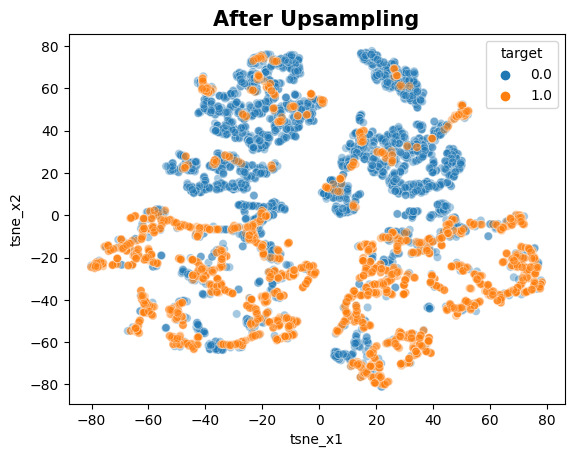

In [51]:
# sns.scatterplot(data=after_upsampling, x='pca_x1', y='pca_x2', hue='target', alpha=0.4)
# plt.title('After Upsampling', fontsize=15, fontweight='semibold')
# plt.show()

sns.scatterplot(data=after_upsampling, x='tsne_x1', y='tsne_x2', hue='target', alpha=0.4)
plt.title('After Upsampling', fontsize=15, fontweight='semibold')
plt.show()

### 2) Upsampling 방법에 따른 성능 차이

In [52]:
X_test_d = X_test.drop('time', axis=1)

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

In [54]:
X_smote, y_smote = SMOTE().fit_resample(X_train, y_train)
clf_smote = RandomForestClassifier(random_state=0).fit(X_smote, y_smote)

X_adasyn, y_adasyn = ADASYN().fit_resample(X_train, y_train)
clf_adasyn = RandomForestClassifier(random_state=0).fit(X_adasyn, y_adasyn)

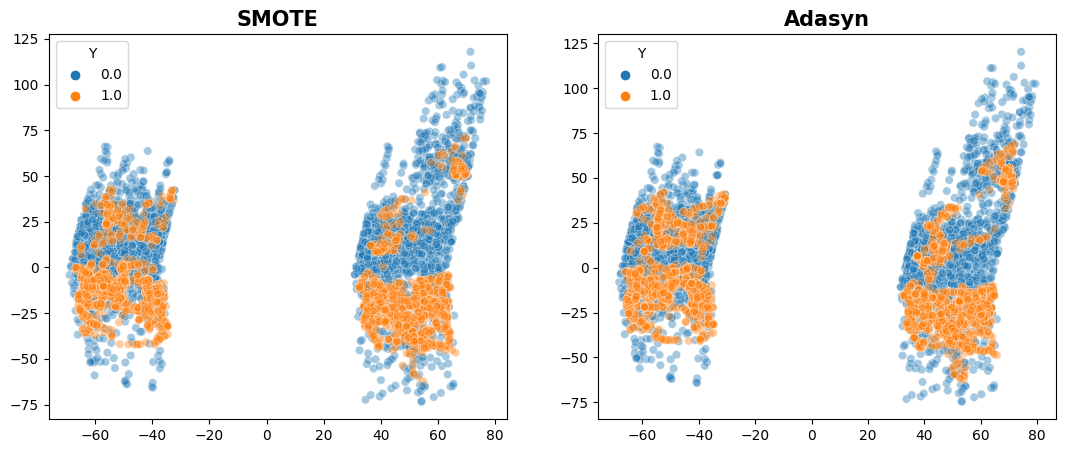

In [55]:
fig, axs = plt.subplots(1,2, figsize = (13,5))
pca_smote = PCA(n_components=2, random_state=0)
smote = pca_smote.fit_transform(X_smote)

sns.scatterplot(x=smote[:,0], y=smote[:,1], hue=y_smote, alpha=0.4, ax=axs[0])
axs[0].set_title('SMOTE', fontsize=15, fontweight='semibold')

pca_adasyn = PCA(n_components=2, random_state=0)
adasyn = pca_smote.fit_transform(X_adasyn)

sns.scatterplot(x=adasyn[:,0], y=adasyn[:,1], hue=y_adasyn, alpha=0.4, ax=axs[1])
axs[1].set_title('Adasyn', fontsize=15, fontweight='semibold')

plt.show()

In [56]:
test_smote = clf_smote.predict(X_test_d)
test_adasyn = clf_adasyn.predict(X_test_d)

print('---SMOTE with RandomForest---')
print('Test Accuracy Score:', accuracy_score(y_test, test_smote))
print('Test AUC Score:', roc_auc_score(y_test, test_smote))
print('Test F1 score:', f1_score(y_test, test_smote))
print()
print('---Adasyn with RandomForest---')
print('Test Accuracy Score:', accuracy_score(y_test, test_adasyn))
print('Test AUC Score:', roc_auc_score(y_test, test_adasyn))
print('Test F1 score:', f1_score(y_test, test_adasyn))

---SMOTE with RandomForest---
Test Accuracy Score: 0.8907849829351536
Test AUC Score: 0.8545791665738659
Test F1 score: 0.6643356643356644

---Adasyn with RandomForest---
Test Accuracy Score: 0.8805460750853242
Test AUC Score: 0.8558264103877592
Test F1 score: 0.6488294314381271


## 3.4 스케일링

In [57]:
X_train = X_train_smote
y_train = y_train_smote

In [58]:
categorical_columns = ['year', 'month', 'day', 'hour', 'dayofweek']
numerical_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate']

In [59]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse_output=False)

preprocessor = make_column_transformer(
    (scaler, numerical_columns),
    (ohe, categorical_columns),
)

In [60]:
X_train

,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,year,month,day,dayofweek
0,20210909,8,17.216667,42.000000,98.062954,100.000000,100.000000,26.756302,8.518336,95.546264,2021,9,9,3
1,20211011,0,16.322222,36.000000,99.367089,99.689441,100.000000,28.663898,21.200839,102.506394,2021,10,11,0
2,20210903,13,16.523333,28.000000,99.215686,100.000000,100.000000,18.851152,19.827752,101.484361,2021,9,3,4
3,20210919,19,22.244444,40.000000,98.855152,99.947671,99.004975,54.186202,23.984737,93.996227,2021,9,19,6
4,20210919,19,3.853170,10.000000,90.000000,100.000000,100.000000,10.538139,10.469460,99.397590,2021,9,19,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6079,20211019,12,5.945555,12.832214,57.623365,99.064928,97.622245,13.108305,18.853222,105.796671,2021,10,19,1
6080,20210919,12,2.890281,8.375148,93.517982,100.000000,100.000000,6.819312,4.176310,101.057957,2021,9,19,2
6081,20210917,8,5.148236,11.437666,62.834659,99.232256,100.000000,11.768221,18.175449,104.387784,2021,9,17,4
6082,20210910,10,7.792934,16.331437,72.077724,99.407563,100.000000,12.861075,25.978966,103.275465,2021,9,10,4


In [61]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['connect_avg', 'connect_max',
                                  'in_handover_rate', 'out_handover_rate',
                                  'inter_handover_rate', 'lower_prb',
                                  'upper_prb', 'reconfig_rate']),
                                ('onehotencoder',
                                 OneHotEncoder(sparse_output=False),
                                 ['year', 'month', 'day', 'hour',
                                  'dayofweek'])])

In [62]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 4.모델 적용

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

## 4.1 LR, DT, RF, XGB

In [64]:
def plot_confusion_matrix(model_name, y_test, predict, ax=None):
    plt.figure(figsize=(4,4))
    accuracy = accuracy_score(y_test, predict)
    f1 = f1_score(y_test, predict)
    plt.suptitle(f'{model_name} Confusion Matrix')
    plt.title(f'Accuracy Score: {accuracy:.2f}, F1 Score: {f1:.2f}')
    sns.heatmap(confusion_matrix(y_test, predict),
                annot=True, cmap='Blues',
                fmt='d',
                annot_kws={'size':15, 'weight':'normal'},
                ax=ax)
    plt.tight_layout()
    plt.show()

In [65]:
estimators = [
    ('Logistic Regression', LogisticRegression(random_state=0, max_iter=1000)),
    ('SVM', SVC(random_state=0)),
    ('Decision Tree', DecisionTreeClassifier(random_state=0)),
    ('Random Forest', RandomForestClassifier(random_state=0)),
    ('XGBoost', XGBClassifier(random_state=0))
]

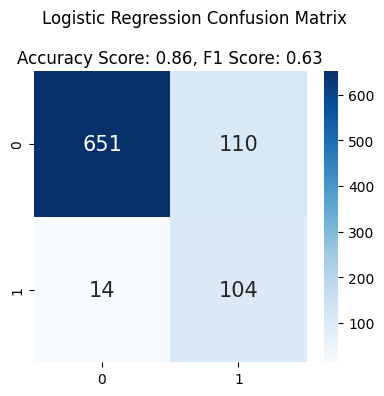

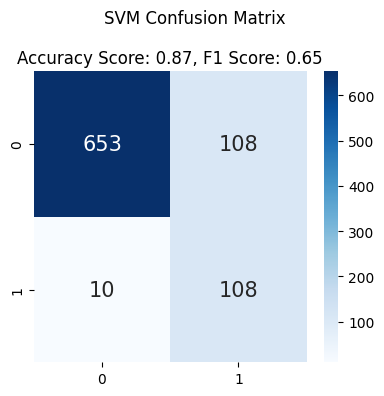

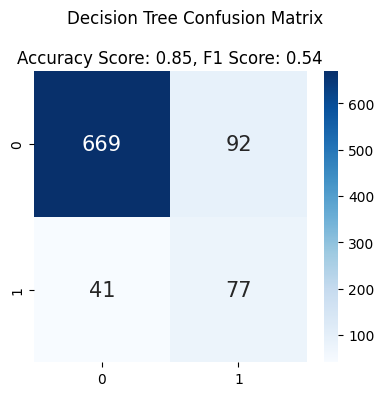

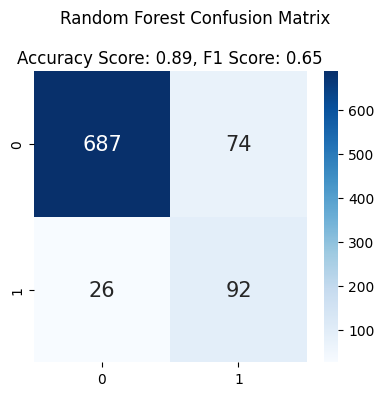

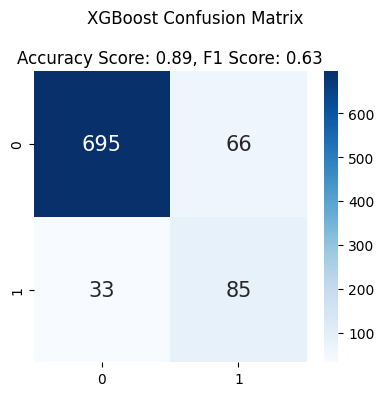

In [66]:
for name, model in estimators:
    model = model
    model.fit(X_train_processed, y_train)
    prediction = model.predict(X_test_processed)
    plot_confusion_matrix(name, y_test, prediction)

## 4.2 Sine, Cosine Transform

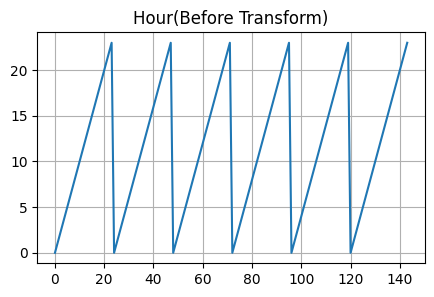

In [67]:
trainX['hour'][:24*6].plot(figsize=(5,3), title='Hour(Before Transform)', grid=True)
plt.show()

In [68]:
trainX['sin_hour'] = np.sin(trainX['hour']/24*2*np.pi)
trainX['cos_hour'] = np.cos(trainX['hour']/24*2*np.pi)

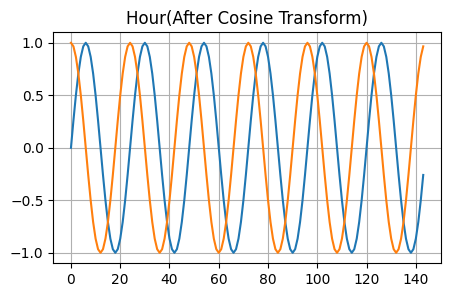

In [69]:
trainX['sin_hour'][:24*6].plot(figsize=(5,3), title='Hour(After Sine Transform)', grid=True)
trainX['cos_hour'][:24*6].plot(figsize=(5,3), title='Hour(After Cosine Transform)', grid=True)
plt.show()

In [70]:
trainX['sin_day'] = np.sin(trainX['day']/31*2*np.pi)
trainX['cos_day'] = np.cos(trainX['day']/31*2*np.pi)

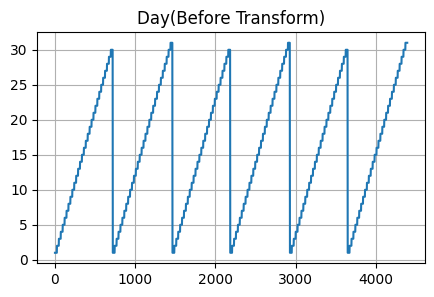

In [71]:
trainX['day'].plot(figsize=(5,3), title='Day(Before Transform)', grid=True)
plt.show()

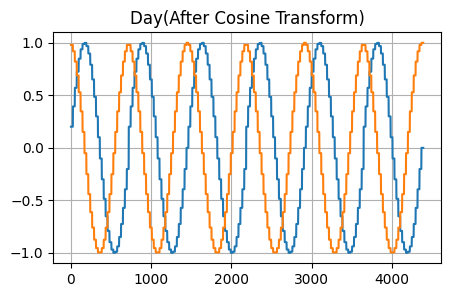

In [72]:
trainX['sin_day'].plot(figsize=(5,3), title='Day(After Sine Transform)', grid=True)
trainX['cos_day'].plot(figsize=(5,3), title='Day(After Cosine Transform)', grid=True)
plt.show()

In [73]:
trainX['sin_dayofweek'] = np.sin(trainX['dayofweek']/7*2*np.pi)
trainX['cos_dayofweek'] = np.cos(trainX['dayofweek']/7*2*np.pi)

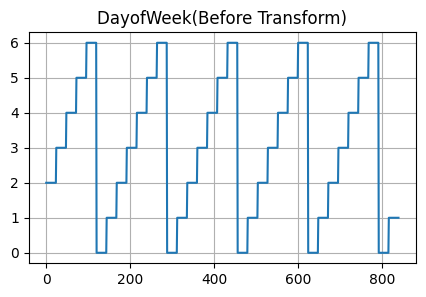

In [74]:
trainX['dayofweek'][:24*7*5].plot(figsize=(5,3), title='DayofWeek(Before Transform)', grid=True)
plt.show()

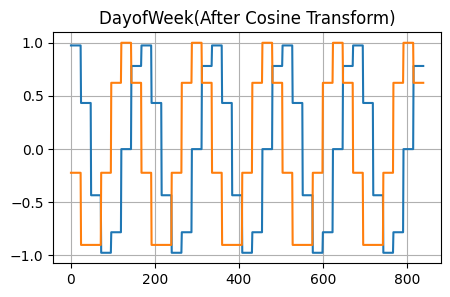

In [75]:
trainX['sin_dayofweek'][:24*7*5].plot(figsize=(5,3), title='DayofWeek(After Sine Transform)', grid=True)
trainX['cos_dayofweek'][:24*7*5].plot(figsize=(5,3), title='DayofWeek(After Cosine Transform)', grid=True)
plt.show()

## 4.3 데이터 분리 및 전처리

In [76]:
trainX.columns

Index(['date', 'hour', 'connect_avg', 'connect_max', 'in_handover_rate',
       'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb',
       'reconfig_rate', 'time', 'year', 'month', 'day', 'dayofweek',
       'sin_hour', 'cos_hour', 'sin_day', 'cos_day', 'sin_dayofweek',
       'cos_dayofweek'],
      dtype='object')

In [77]:
categorical_columns = ['year', 'month']
numerical_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.2, random_state=0, stratify=trainY)

scaler = StandardScaler()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

preprocessor = make_column_transformer(
    (scaler, numerical_columns),
    (ohe, categorical_columns),
    ('passthrough', ['sin_hour', 'cos_hour', 'sin_day', 'cos_day', 'sin_dayofweek', 'cos_dayofweek']),
    ('drop', ['date'])
)

preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [79]:
pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out()).head()

,standardscaler__connect_avg,standardscaler__connect_max,standardscaler__in_handover_rate,standardscaler__out_handover_rate,standardscaler__inter_handover_rate,standardscaler__lower_prb,standardscaler__upper_prb,standardscaler__reconfig_rate,onehotencoder__year_2021,onehotencoder__month_9,onehotencoder__month_10,passthrough__sin_hour,passthrough__cos_hour,passthrough__sin_day,passthrough__cos_day,passthrough__sin_dayofweek,passthrough__cos_dayofweek
0,0.230775,0.724044,0.467587,0.229596,0.178323,0.383020,-0.637007,-0.544553,1.0,1.0,0.0,0.866025,-0.500000,0.968077,-0.250653,0.433884,-0.900969
1,0.157713,0.409898,0.535967,-0.200282,0.178323,0.506835,0.584591,0.610224,1.0,0.0,1.0,0.000000,1.000000,0.790776,-0.612106,0.000000,1.000000
2,0.174141,-0.008965,0.528029,0.229596,0.178323,-0.130073,0.452333,0.440656,1.0,1.0,0.0,-0.258819,-0.965926,0.571268,0.820763,-0.433884,-0.900969
3,0.641462,0.619329,0.509125,0.157162,-0.218977,2.163392,0.852741,-0.801724,1.0,1.0,0.0,-0.965926,0.258819,-0.651372,-0.758758,-0.781831,0.623490
4,-0.860804,-0.951405,0.044821,0.229596,0.178323,-0.669640,-0.449072,0.094433,1.0,1.0,0.0,-0.965926,0.258819,-0.651372,-0.758758,-0.781831,0.623490


## 4.3 RandomForest & SVC

In [80]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_processed, y_train)

svc = SVC(random_state=0, probability=True)
svc.fit(X_train_processed, y_train)

SVC(probability=True, random_state=0)

In [81]:
rf_predict = rf.predict(X_train_processed)

print('RF Train')
print('Train Accuracy Score:', accuracy_score(y_train, rf_predict).round(4))
print('Train F1 score:', f1_score(y_train, rf_predict).round(4))

svc_predict = svc.predict(X_train_processed)
print('\nSVC Train')
print('Train Accuracy Score:', accuracy_score(y_train, svc_predict).round(4))
print('Train F1 score:', f1_score(y_train, svc_predict).round(4))

RF Train
Train Accuracy Score: 0.9997
Train F1 score: 0.9989

SVC Train
Train Accuracy Score: 0.9254
Train F1 score: 0.6953


In [82]:
rf_predict = rf.predict(X_test_processed)

print('RF test')
print('Test Accuracy Score:', accuracy_score(y_test, rf_predict).round(4))
print('Test F1 score:', f1_score(y_test, rf_predict).round(4))

svc_predict = svc.predict(X_test_processed)
print('\nSVC test')
print('Test Accuracy Score:', accuracy_score(y_test, svc_predict).round(4))
print('Test F1 score:', f1_score(y_test, svc_predict).round(4))

RF test
Test Accuracy Score: 0.9147
Test F1 score: 0.6606

SVC test
Test Accuracy Score: 0.9192
Test F1 score: 0.6844


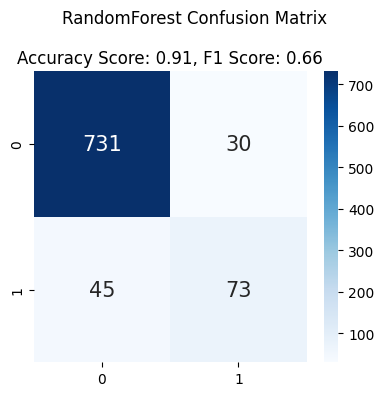

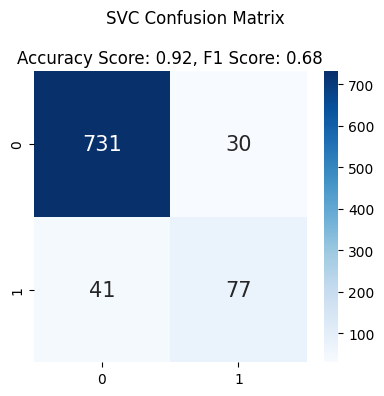

In [83]:
plot_confusion_matrix('RandomForest', y_test, rf_predict)
plot_confusion_matrix('SVC', y_test, svc_predict)

## 4.4 ROC Curve

In [84]:
train_predict_rf = rf.predict_proba(X_train_processed)
test_predict_rf = rf.predict_proba(X_test_processed)

train_predict_svc = svc.predict_proba(X_train_processed)
test_predict_svc = svc.predict_proba(X_test_processed)

In [85]:
def plot_roc(name, labels, predictions, **kwargs):
  fpr, tpr, _ = roc_curve(labels, predictions)
  plt.plot(fpr, tpr, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.grid(True)
#   ax = plt.gca()
#   ax.set_aspect('equal')

In [86]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [87]:
print('RF Train AUC Score:', roc_auc_score(y_train, train_predict_rf[:,1]))
print('RF Test AUC score:', roc_auc_score(y_test, test_predict_rf[:,1]))
print()
print('SVC Train AUC Score:', roc_auc_score(y_train, train_predict_svc[:,1]))
print('SVC Test AUC score:', roc_auc_score(y_test, test_predict_svc[:,1]))

RF Train AUC Score: 1.0
RF Test AUC score: 0.935499677052941

SVC Train AUC Score: 0.9258170468361552
SVC Test AUC score: 0.916913517004833


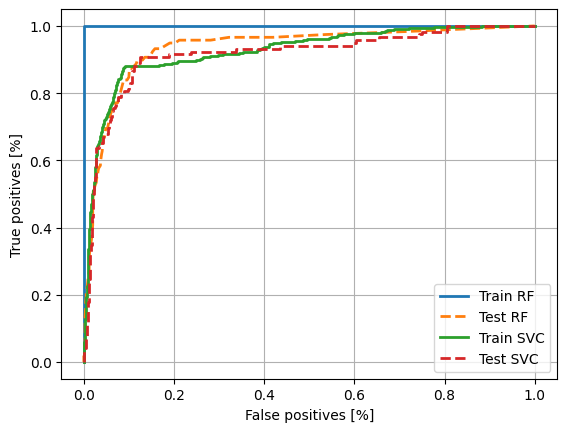

In [88]:
plot_roc("Train RF", y_train, train_predict_rf[:,1], color=colors[0])
plot_roc("Test RF", y_test, test_predict_rf[:,1], color=colors[1], linestyle='--')

plot_roc("Train SVC", y_train, train_predict_svc[:,1], color=colors[2])
plot_roc("Test SVC", y_test, test_predict_svc[:,1], color=colors[3], linestyle='--')

plt.legend(loc='lower right');

# 5.OOB적용

## 5.1 데이터 처리

In [89]:
OOB = '/content/drive/MyDrive/ASAC3기_이상탐지/Code/5주차/이승용/oob.csv'
oob_org = pd.read_csv(OOB)

In [90]:
oob_org.head(2)

,ckey,machine_id,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate
0,MA1004_0-20210901-0,MA1004_0,20210901,0,27.913285,43.0,97.523220,100.0,100.0,45.402603,59.021408,100.409763
1,MA1004_0-20210901-1,MA1004_0,20210901,1,23.013333,36.0,98.170732,NaN,100.0,36.740540,21.128778,99.953052


In [91]:
oob_org.fillna(method='ffill', inplace=True)
oob_org['time'] = pd.to_datetime(oob_org['date'].astype(str)+oob_org['hour'].astype(str), format='%Y%m%d%H')

oob = oob_org.drop(['ckey', 'machine_id'], axis=1)

oob['year'] = oob['time'].dt.year
oob['month'] = oob['time'].dt.month
oob['day'] = oob['time'].dt.day
oob['hour'] = oob['time'].dt.hour
oob['dayofweek'] = oob['time'].dt.dayofweek

In [92]:
oob['sin_hour'] = np.sin(oob['hour']/24*2*np.pi)
oob['cos_hour'] = np.cos(oob['hour']/24*2*np.pi)

oob['sin_day'] = np.sin(oob['day']/31*2*np.pi)
oob['cos_day'] = np.cos(oob['day']/31*2*np.pi)

oob['sin_dayofweek'] = np.sin(oob['dayofweek']/7*2*np.pi)
oob['cos_dayofweek'] = np.cos(oob['dayofweek']/7*2*np.pi)

In [93]:
oob.sample()

,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,...,year,month,day,dayofweek,sin_hour,cos_hour,sin_day,cos_day,sin_dayofweek,cos_dayofweek
30267,20211012,3,4.564444,11.0,100.0,100.0,100.0,3.220683,0.483129,96.573427,...,2021,10,12,1,0.707107,0.707107,0.651372,-0.758758,0.781831,0.62349


In [94]:
oob_processed = preprocessor.transform(oob)

In [95]:
prediction = svc.predict(oob_processed)

## 5.2 Inference

In [96]:
oob_org['preds'] = prediction

In [97]:
oob_org['preds'].value_counts()

0.0    38062
1.0        2
Name: preds, dtype: int64

In [98]:
anomalies_count = oob_org.groupby(['machine_id','preds']).size().to_frame('count').reset_index()

In [99]:
anomalies_count.head()

,machine_id,preds,count
0,MA1004_0,0.0,1464
1,MA1004_10,0.0,1464
2,MA1005_1,0.0,1464
3,MA1005_2,0.0,1464
4,MA1005_7,0.0,1464


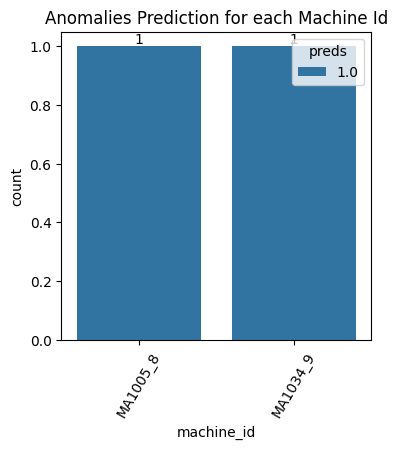

In [100]:
plt.figure(figsize=(4,4))
plt.title('Anomalies Prediction for each Machine Id')
sns.barplot(data=anomalies_count[anomalies_count['preds']==1.0], x='machine_id', y='count', hue='preds')
ax = plt.gca()
for i in ax.containers:
    ax.bar_label(i)
plt.xticks(rotation=60)
plt.show()

# 6.Feature Importance

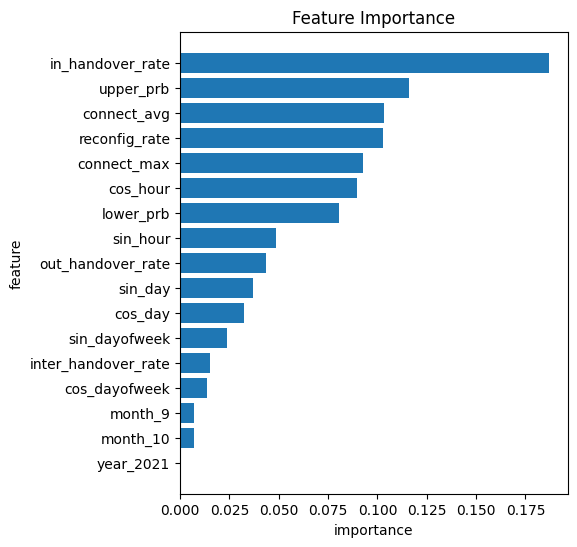

In [101]:
feature_importance = rf.feature_importances_
feature_names = [col.split('__')[1] for col in preprocessor.get_feature_names_out()]
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance.sort_values('importance', ascending=True, inplace=True)
feature_importance.head(20)
plt.figure(figsize=(5,6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('Feature Importance')
plt.show()

# 7.Tree Visualization

In [102]:
from sklearn.tree import export_graphviz
import graphviz
import pydot

In [103]:
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train_processed, y_train)

DecisionTreeClassifier(random_state=0)

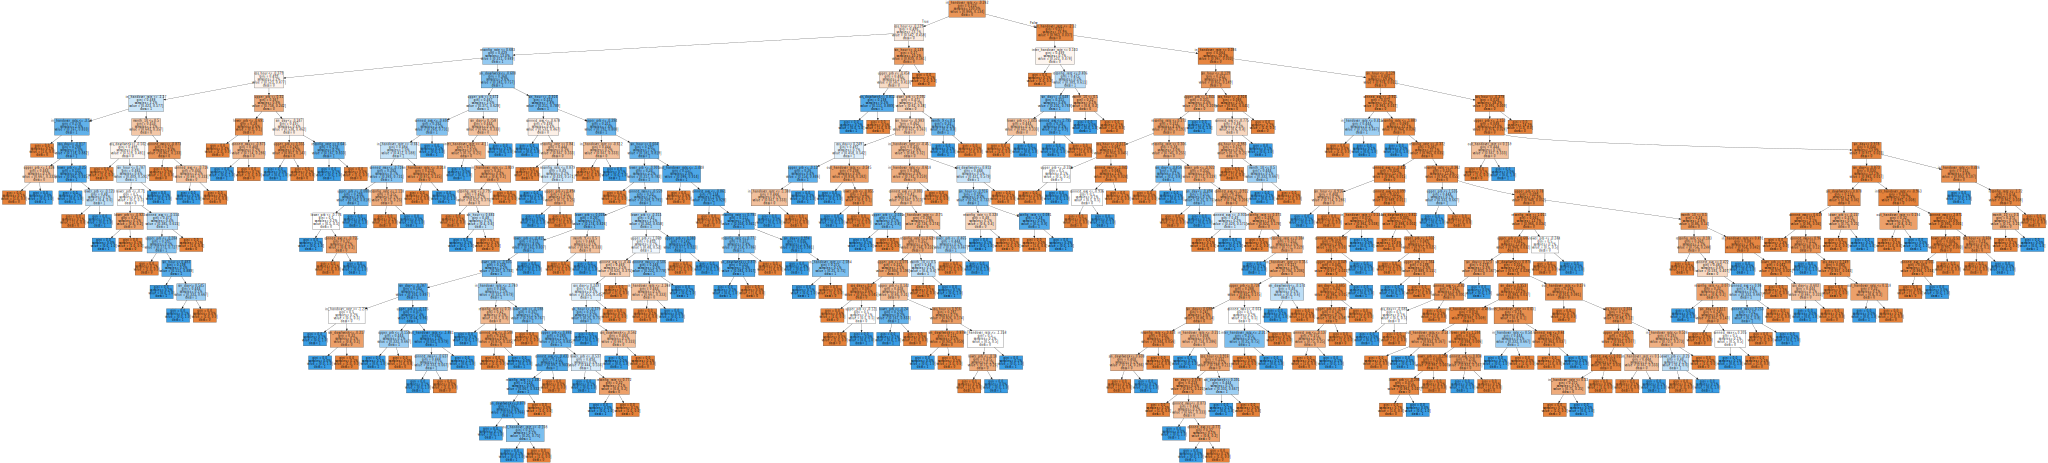

In [104]:
# export_graphviz() 호출 결과로 out_file로 지정된 tree.dot 파일을 생성
dot_data = export_graphviz(dt
                           , feature_names=feature_names
                           , class_names=['0','1']
                           , filled=True
                           , proportion=True)

pdot = pydot.graph_from_dot_data(dot_data)[0]
graph = graphviz.Source(dot_data, format='png')
display(graph)

# 번외)Time Series Imputation
출처 : [시계열 데이터 전처리](https://velog.io/@leeebs/%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A0%84%EC%B2%98%EB%A6%AC)
- 시계열에서의 결측치 처리
    - 대부분의 시계열은 비정상 데이터로 시간에 따라 평균과 분산이 변함
    - 이를 고려한 결측치 처리 방식이 필요
- imputation :
- 불완전한 데이터가 있을 때 표준이나 대표성이 있는 다른 데이터를 활용하여 대체될 수 있는 값들로 계산하여 입력하는 과정
    - 일반적인 imputation
        - mean/median
        - frequent value
        - ML Imputation
    - 시계열의 단순한 imputation
        - Last observation carried forward(LOCF) : 직전 관측치 값으로 결측치 대체
        - Next observation carried backward(NOCB) : 직후 관측치 값으로 결측치 대체
        - Moving Average/Median : 직전 N의 time window의 평균치/중앙값으로 결측치 대체
- interpolation :
    - 통계적으로 이미 구해진 데이터들로부터 주어진 데이터를 만족하는 근사 함수를 구하는 방법론
        - 선형 보간 : 근사 함수로 선형 함수 가정
        - 비선형 보간 : 근사 함수로 비선형 함수 가정
        - 스플라인(spline) 보간 : 전체 구간을 전체 구간이 아닌 소구간을 나누어 보간

- Noise :
    - 잡음을 뜻하며 데이터에서 노이즈란 다른 외부 요인의 간섭과 같은 여러 가지 의도하지 않은 데이터의 왜곡을 불러오는 모든 것을 의미
    - Moving Average :
    - Filtering :  
        - 1) 가우시안 필터링(Gaussian Filtering)
            - 노이즈가 정규분포를 따른다고 가정함(일반적으로 노이즈는 정규분포를 따름)
        - 2) 쌍방 필터(Bilateral Filter)
            - 변곡점이 큰 지점을 뭉개버린다는 특징을 갖는 가우시안 필터링의 단점을 보완
            - 데이터의 원 분포에 따라 발생하는 엣지(edge)들을 더 잘 보존할 수 있음
        - 3) 칼만 필터(Kalman Filter)
            - 현재 상태의 결합분포를 추정하는 모델링 알고리즘으로 잡음이 포함된 과거 측정값에서 현재 상태의 결합분포를 추정하는 알고리즘
            - 일반화된 분포를 가정하는 것이 아닌 데이터의 특성에 맞는 분포를 모델링할 수 있어 상당히 많이 사용되는 알고리즘

### 1) interpolation(linear, polynomial, spline) 결과

In [105]:
from scipy.interpolate import interp1d

In [106]:
df = df_org.copy()

In [107]:
df.machine_id.unique()

array(['MA1074_4', 'MA1084_11', 'MA1116_1'], dtype=object)

In [108]:
df.loc[df['machine_id']=='MA1084_11',:].isna().sum()

ckey                    0
machine_id              0
date                    0
hour                    0
connect_avg             4
connect_max             4
in_handover_rate        4
out_handover_rate      23
inter_handover_rate    72
lower_prb               5
upper_prb               5
reconfig_rate           4
Y                       0
dtype: int64

In [109]:
df.loc[(df['machine_id']=='MA1084_11')&(df['upper_prb'].isna()),:]

,ckey,machine_id,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,Y
2474,MA1084_11-20211013-2,MA1084_11,20211013,2,NaN,NaN,NaN,83.333333,100.0,NaN,NaN,NaN,0.0
2475,MA1084_11-20211013-3,MA1084_11,20211013,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2476,MA1084_11-20211013-4,MA1084_11,20211013,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2889,MA1084_11-20211030-9,MA1084_11,20211030,9,5.291829,12.0,47.368421,100.000000,100.0,NaN,NaN,102.025506,1.0
2925,MA1084_11-20211031-21,MA1084_11,20211031,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


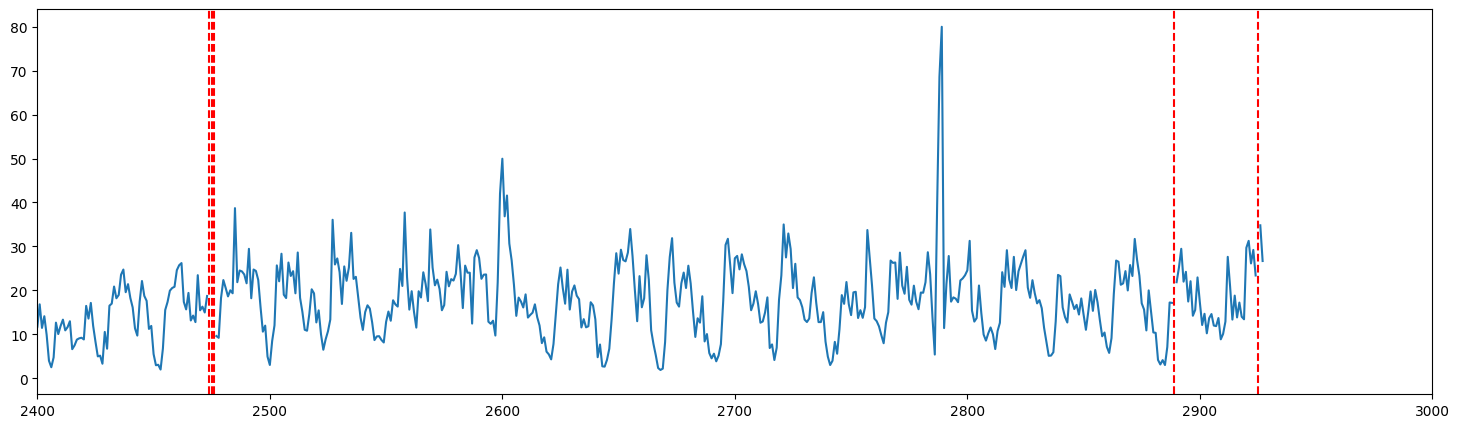

In [110]:
df.loc[df['machine_id']=='MA1084_11',"upper_prb"].plot(kind='line', figsize=(18,5))
for x in df.loc[(df['machine_id']=='MA1084_11')&(df['upper_prb'].isna()),:].index:
    plt.axvline(x=x, color='red', ls='--')
plt.xlim((2400, 3000))
plt.show()

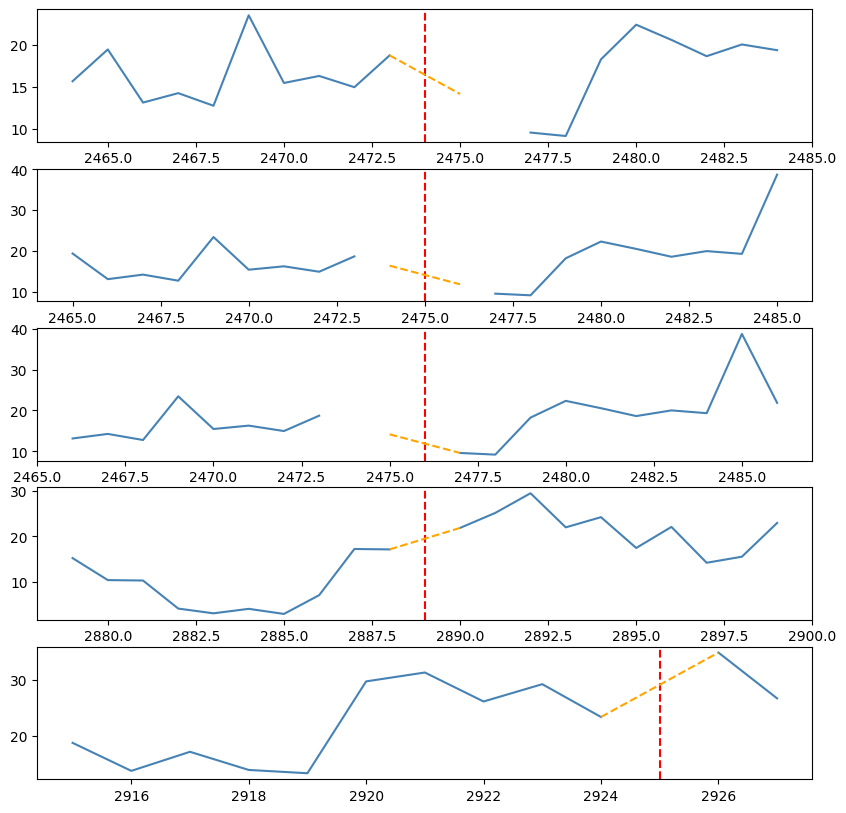

In [111]:
tmp = df.loc[df['machine_id']=='MA1084_11',"upper_prb"]
tmp_inp = df.loc[df['machine_id']=='MA1084_11',"upper_prb"].interpolate(method='linear')
fig,axs = plt.subplots(5, figsize=(10,10))
for idx, time_idx in enumerate(df.loc[(df['machine_id']=='MA1084_11')&(df['upper_prb'].isna()),:].index):
    start_time = time_idx - 10
    end_time = time_idx + 10
    start = time_idx - 1
    end = time_idx + 1
    axs[idx].axvline(x=time_idx, color='red', ls='--')
    axs[idx].plot(tmp.loc[start_time:end_time], color='steelblue')
    axs[idx].plot(tmp_inp.loc[start:end], color='orange', ls='--')

plt.show()

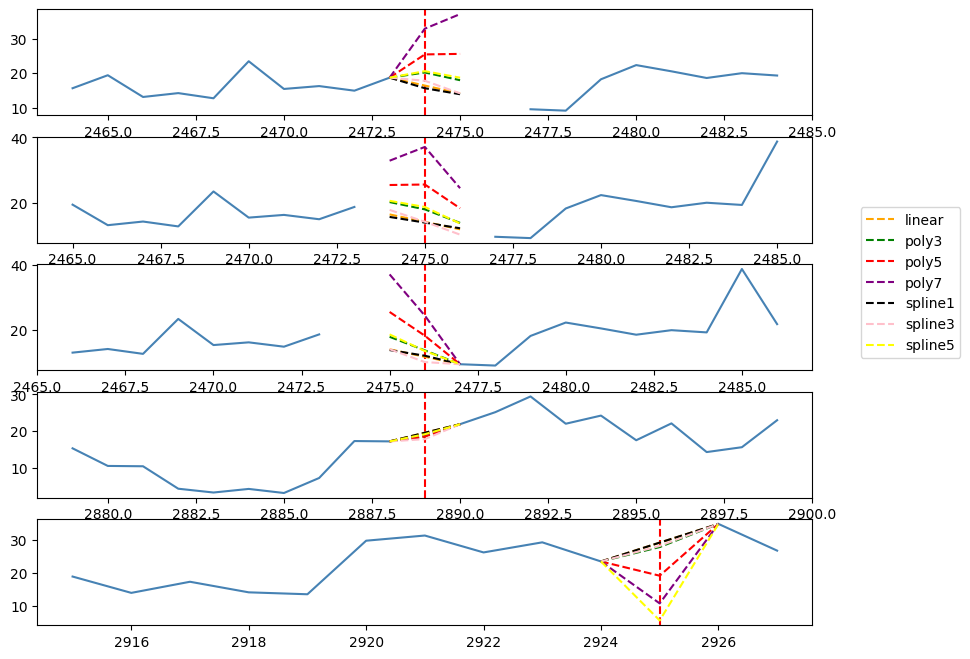

In [112]:
tmp = df.loc[df['machine_id']=='MA1084_11',"upper_prb"]
tmp_linear = df.loc[df['machine_id']=='MA1084_11',"upper_prb"].interpolate(method='linear')
tmp_poly3 = df.loc[df['machine_id']=='MA1084_11',"upper_prb"].interpolate(method='polynomial', order=3)
tmp_poly5 = df.loc[df['machine_id']=='MA1084_11',"upper_prb"].interpolate(method='polynomial', order=5)
tmp_poly7 = df.loc[df['machine_id']=='MA1084_11',"upper_prb"].interpolate(method='polynomial', order=7)
tmp_spline1 = df.loc[df['machine_id']=='MA1084_11',"upper_prb"].interpolate(method='spline', order=1)
tmp_spline3 = df.loc[df['machine_id']=='MA1084_11',"upper_prb"].interpolate(method='spline', order=3)
tmp_spline5 = df.loc[df['machine_id']=='MA1084_11',"upper_prb"].interpolate(method='spline', order=5)


fig,axs = plt.subplots(5, figsize=(10,8)) #, gridspec_kw={'hspace':0})
for idx, time_idx in enumerate(df.loc[(df['machine_id']=='MA1084_11')&(df['upper_prb'].isna()),:].index):
    start_time = time_idx - 10
    end_time = time_idx + 10
    start = time_idx - 1
    end = time_idx + 1
    axs[idx].axvline(x=time_idx, color='red', ls='--')
    axs[idx].plot(tmp.loc[start_time:end_time], color='steelblue')
    axs[idx].plot(tmp_linear.loc[start:end], color='orange', ls='--', label='linear')
    axs[idx].plot(tmp_poly3.loc[start:end], color='green', ls='--', label='poly3')
    axs[idx].plot(tmp_poly5.loc[start:end], color='red', ls='--', label='poly5')
    axs[idx].plot(tmp_poly7.loc[start:end], color='purple', ls='--', label='poly7')
    axs[idx].plot(tmp_spline1.loc[start:end], color='black', ls='--', label='spline1')
    axs[idx].plot(tmp_spline3.loc[start:end], color='pink', ls='--', label='spline3')
    axs[idx].plot(tmp_spline5.loc[start:end], color='yellow', ls='--', label='spline5')
    # axs[idx].set_xticks([],[])
plt.legend(bbox_to_anchor=(1.2, 4))
plt.show()

### 2) interpolation에 따른 성능 차이

In [113]:
from sklearn.metrics import classification_report

In [114]:
tmp_linear = df.interpolate(method='linear')
tmp_poly3 = df.interpolate(method='polynomial', order=3)
tmp_poly5 = df.interpolate(method='polynomial', order=5)
tmp_poly7 = df.interpolate(method='polynomial', order=7)
tmp_spline1 = df.interpolate(method='spline', order=1)
tmp_spline3 = df.interpolate(method='spline', order=3)
tmp_spline5 = df.interpolate(method='spline', order=5)

In [115]:
def interpolation_test(name, df):
    X = df.drop(['ckey','machine_id', 'Y'], axis=1)
    y = df['Y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y)
    svc = SVC(random_state=0, probability=True)
    svc.fit(X_train, y_train)
    prediction = svc.predict_proba(X_test)
    print('-'*35)
    print(f'{name} Test Result')
    print(print('f1 score :', f1_score(y_test, prediction)))
    print('-'*35)

In [116]:
# interpolation_dict = {'linear'  : tmp_linear,
#                       'poly3'   : tmp_poly3,
#                       'poly5'   : tmp_poly5,
#                       'poly7'   : tmp_poly7,
#                       'spline1' : tmp_spline1,
#                       'spline3' : tmp_spline3,
#                       'spline5' : tmp_spline5}
# for name, cand in interpolation_dict.items():
#     interpolation_test(name, cand)